# Imputation Comparison

[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ing-bank/probatus/blob/master/docs/tutorials/nb_imputation_comparison.ipynb)

This notebook explains how the `ImputationSelector` class works in `probatus`. With `ImputationSelector` you can compare multiple imputation strategies
and choose a strategy which works the best for a given model and a dataset.
Currently `ImputationSelector` supports any [scikit-learn](https://scikit-learn.org/stable/) compatible imputation strategy. For categorical variables the missing values are replaced by a `missing` token and `OneHotEncoder` is applied. The user-supplied imputation strategies are applied to numerical columns only. 
Support for user-supplied imputation strategies for categorical columns can be added in the future releases.

Let us look at an example and start by importing all the required classes and methods.



In [1]:
###Install the packages
# %%capture
#!pip install probatus
#!pip install lightgbm

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_row", 500)
pd.set_option("display.max_colwidth", 200)
import lightgbm as lgb
from sklearn.datasets import make_classification
from sklearn.experimental import enable_iterative_imputer

from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression

from probatus.missing_values.imputation import ImputationSelector
from probatus.utils.missing_helpers import generate_MCAR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Let's create a classification dataset to apply the various imputation strategies.

We'll use the `probatus.utils.missing_helpers.generate_MCAR` function to randomly add missing values to the dataset.

In [4]:
n_features = 20
X, y = make_classification(n_samples=2000, n_features=n_features, random_state=123, class_sep=0.3)
X = pd.DataFrame(X, columns=["f_" + str(i) for i in range(0, n_features)])
print(f"Shape of X,y : {X.shape},{y.shape}")

Shape of X,y : (2000, 20),(2000,)


In [5]:
X_missing = generate_MCAR(X, missing=0.2)
missing_stats = pd.DataFrame(X_missing.isnull().mean())

missing_stats.head()

ValueError: Shape of passed values is (20, 1), indices imply (20, 0)

The data has approximately 20% missing values in each feature.

## Imputation Strategies

Create a dictionary with all the strategies to compare. Also, create a classifier to use for evaluating various strategies.
If the model supports handling of missing features by default then the model performance on an unimputed dataset is calculated. You can indicate that the model supports handling missing values by setting the parameter `model_na_support=True`.
The model performance against the unimputed dataset can be found in `No Imputation` results.

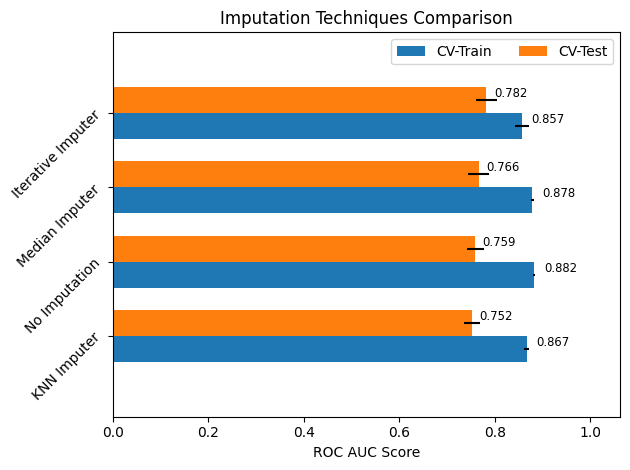

[LightGBM] [Info] Number of positive: 802, number of negative: 798
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501250 -> initscore=0.005000
[LightGBM] [Info] Start training from score 0.005000
[LightGBM] [Info] Number of positive: 802, number of negative: 798
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501250 -> initscore=0.005000
[LightGBM] [Info] Start training from score 0.005000
[LightGBM] [Info] Number o

In [6]:
strategies = {
    "KNN Imputer": KNNImputer(n_neighbors=3),
    "Median Imputer": SimpleImputer(strategy="median", add_indicator=True),
    "Iterative Imputer": IterativeImputer(add_indicator=True, n_nearest_features=5, sample_posterior=True),
}

clf = lgb.LGBMClassifier(n_estimators=2)
cmp = ImputationSelector(clf=clf, strategies=strategies, cv=5, random_state=45, model_na_support=True)
cmp.fit_compute(X_missing, y)
result_plot = cmp.plot()

However if the model does not support missing values by default (e.g. `LogisticRegression`), results for only the imputation strategies are calculated. 


In [ ]:
clf = LogisticRegression()
cmp = ImputationSelector(clf=clf, strategies=strategies, cv=5)
cmp.fit_compute(X_missing, y)
result_plot = cmp.plot()

You can also pass a sklearn pipeline instead of a classifier.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

steps = [("scaler", StandardScaler()), ("LR", LogisticRegression())]
clf = Pipeline(steps)
cmp = ImputationSelector(clf=clf, strategies=strategies, cv=5, model_na_support=False)
cmp.fit_compute(X_missing, y)
result_plot = cmp.plot()

## Scikit Learn Compatible Imputers. 

You can also use any other scikit-learn compatible imputer as an imputing strategy.
e.g. [feature engine](https://feature-engine.readthedocs.io/en/latest/index.html) library provides a host of other imputing stratgies as well. You can pass them for comparision as well.